# Project 2: Data Representations and Clustering
#### Serena Tang, Liwen Yang, Winston Wang

### Clustering with Sparse Text Representations

*1. Generate sparse TF-IDF representations: Following the steps in Project 1, transform the documents into TF-IDF vectors. Use min df = 3, exclude the stopwords (no need to do stemming or lemmatization), and remove the headers and footers. No need to do any additional data cleaning.*

In [1]:
from sklearn.datasets import fetch_20newsgroups

# get dataset
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                  'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
newsgroups = fetch_20newsgroups(categories=categories, remove=('headers', 'footers'))

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english')
newsgroups_vectorized = tf_vectorizer.fit_transform(newsgroups.data)

# count vector to TF-IDF
transformer = TfidfTransformer()
newsgroups_tfidf = transformer.fit_transform(newsgroups_vectorized)

print('Newsgroups TF-IDF Dimensions: ', newsgroups_tfidf.shape)

Newsgroups TF-IDF Dimensions:  (4732, 17131)


### QUESTION 1
- ***Report the dimensions of the TF-IDF matrix you obtain.***
    - The newsgroups TF-IDF matrix had a dimension of (4732, 13477). 

*2. Clustering: Apply K-means clustering with k = 2 using the TF-IDF data. Note that the KMeans class in sklearn has parameters named random state, max iter and n init. Please use `random state=0`, `max iter ≥1000`, and `n_init ≥30`. You can refer to sklearn - Clustering text documents using k-means for a basic work flow.*
- *(a) Given the clustering result and ground truth labels, contingency table A is the matrix whose entries $A_{ij}$ is the number of data points that belong to the i’th class and the j’th cluster.*

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Get clusters
kmeans = KMeans(random_state=0, n_clusters=2, max_iter=1000, n_init=30)
kmeans.fit(newsgroups_tfidf )

KMeans(max_iter=1000, n_clusters=2, n_init=30, random_state=0)

In [4]:
# Map the categories to classes
class_1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
class_2=['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
category_to_class=[]
cat_to_num={}
for idx, cat in enumerate(newsgroups.target_names):
    cat_to_num[idx]=cat
for num in newsgroups.target:
    if 'comp.' in cat_to_num[num]:
        category_to_class.append(0)
    else:
        category_to_class.append(1)



<Figure size 432x288 with 0 Axes>

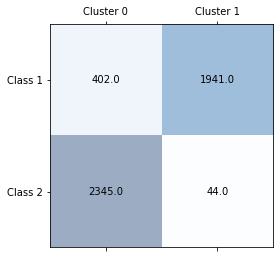

In [5]:
from sklearn import metrics

# plot contingency matrix
fig = plt.figure()
cont_matrix = metrics.cluster.contingency_matrix(category_to_class, kmeans.labels_)
plt.matshow(cont_matrix, cmap=plt.cm.Blues, alpha=0.4)
for (i, j), z in np.ndenumerate(cont_matrix):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xticks(range(2), ['Cluster 0', 'Cluster 1'])
plt.yticks(range(2), ['Class 1', 'Class 2'])
plt.show()


### QUESTION 2

***Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix. Does the contingency matrix have to
be square-shaped?***
- The contingency table of the clustering result is shown above. Based on the strong diagonal, we can infer that `Cluster 1` correlates to `Class 1` and `Cluster 0` correlates to `Class 2`. The contingency matrix should be square-shaped as we set the number of clusters in Kmeans to be 2 and our data has 2 classes. If we set the number of clusters in Kmeans to be a different number than the number of classes in the data, the contingency matrix will not be square. 

# Question 3

In [6]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

print("Adjusted Rand Index score:", adjusted_rand_score(category_to_class, kmeans.labels_))
print("Adjusted mutual information score:", adjusted_mutual_info_score(category_to_class, kmeans.labels_))
print("Homogeneity score:", homogeneity_score(category_to_class, kmeans.labels_))
print("Completeness score:", completeness_score(category_to_class, kmeans.labels_))
print("V-measure score:", v_measure_score(category_to_class, kmeans.labels_))


Adjusted Rand Index score: 0.658454925051644
Adjusted mutual information score: 0.5924279724527073
Homogeneity score: 0.586944967644873
Completeness score: 0.5981422594612767
V-measure score: 0.5924907147701187


# Question 4

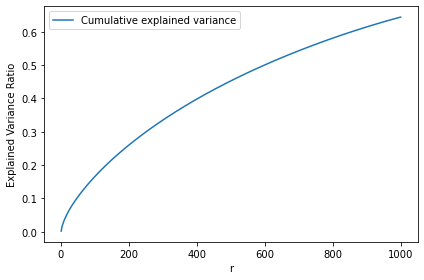

In [7]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=0)
LSI = svd.fit_transform(newsgroups_tfidf)

x = np.array(range(1, 1001))
ratio = svd.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(ratio)

# plt.bar(x, ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(x, cum_sum_eigenvalues,label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('r')
plt.legend(loc='best')
plt.tight_layout()

# Question 5

In [8]:
from sklearn.decomposition import NMF

n_components = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
def Score_plot(reducer, dimension, newsgroups_tfidf, category_to_class):
    ar, am, hs, cs, vs = [],[],[],[],[]
    for n_components in dimension:
        if reducer == "SVD":
            svd = TruncatedSVD(n_components = n_components, random_state=0)
            data = svd.fit_transform(newsgroups_tfidf)
        else:
            nmf = NMF(n_components= n_components, init='random', random_state=0, max_iter=300)
            data = nmf.fit_transform(newsgroups_tfidf)
            
        kmeans = KMeans(random_state=0, n_clusters=2, max_iter=1000, n_init=30)
        kmeans.fit(data)
        
        ar.append(adjusted_rand_score(category_to_class,kmeans.labels_))
        am.append(adjusted_mutual_info_score(category_to_class,kmeans.labels_))
        hs.append(homogeneity_score(category_to_class,kmeans.labels_))
        cs.append(completeness_score(category_to_class,kmeans.labels_))
        vs.append(v_measure_score(category_to_class,kmeans.labels_))
    
    plt.plot(dimension, ar)
    plt.plot(dimension, am)
    plt.plot(dimension, hs)
    plt.plot(dimension, cs)
    plt.plot(dimension, vs)
    
    plt.title('5 scores for ' + reducer)
    plt.xlabel('Dimension')
    plt.ylabel('Scores')
    plt.legend(labels = ['Adjusted Rand Index score','Adjusted mutual information score',
                         'Homogeneity score','Completeness score','V-measure score'])
    
    max_score = max(ar)
    index = ar.index(max_score)
    dimensions = [1,2,3,4,5,6,7,8,9,10,20,50,100,300]
    print("The best choice for "+ reducer +" is when r = ", dimensions[index])

In [ ]:
Score_plot("SVD", n_components, newsgroups_tfidf, category_to_class)

In [ ]:
Score_plot("NMF", n_components, newsgroups_tfidf, category_to_class)

# Question 6

***How do you explain the non-monotonic behavior of the measures as r increases?***

Dimension reduction helps us work with noisy data, but at the same time, we lose some information. Working with few features could indeed help increase the score but not necessarily. 

When we have small r, we only keep dew features of the original data, which may lead to inaccurate result; While when we have large r, we have too much noise in our feature matrix, which may lead to inaccurate clustering by KMeans model, which also affects the accuracy of the model prediction.That is the reason why we have non-monotonic behavior of the measures as r increases.